# Рідж - регресія
 ## Бєлюкіна Тетяна
 Варіант 1

Спочатку я використовую код із 1 лабораторної роботи для отримання вхідного датасету

In [14]:
filenames <- list.files(path="quantquote_daily_sp500_83986/daily", full.names=TRUE)

datalist = lapply(filenames,
    function(x){x0<-read.csv(file=x,header=F)[,c(1,6)];
    colnames(x0)<-c("data",
    unlist(strsplit(x,"[_.]"))[7]);
    x0})

y<-Reduce(function(x,y) {merge(x,y,by="data")}, datalist)  

In [15]:
Data<-y[-nrow(y),-1] #delete the last raw and first column
Data$tomorrow_adbe<-y$adbe[-1] #delete first value in adbe

Виділимо 3 датасети з вхідних даних - датасет для підгонки 1 моделі що містить всі дані і датасет для підгонки 2 моделі що містить останні 50 записів, що передують 20-ти тестовим

In [16]:
nn<-nrow(Data)
test = Data[(nn-19):nn,]
data_for1 = Data[(nn-69):(nn-20),]
data_for2 = Data[1:(nn-20),]

Підженемо модель рідж регресії для наших даних перебираючи коефіцієнт від 0 до 50 з кроком 0.01

In [17]:
library(MASS)
RidgeModel1 <- lm.ridge(tomorrow_adbe ~ .,
            data=data_for1[,!names(data_for1) %in% c("adbe")],lambda = seq(0, 50, .01))
summary(RidgeModel1)

       Length Class  Mode   
coef   45009  -none- numeric
scales     9  -none- numeric
Inter      1  -none- numeric
lambda  5001  -none- numeric
ym         1  -none- numeric
xm         9  -none- numeric
GCV     5001  -none- numeric
kHKB       1  -none- numeric
kLW        1  -none- numeric

Обираємо значення нашого лямбда для якого CV матиме мінімальне значення, це є найбільш якісним значенням для нашої моделі

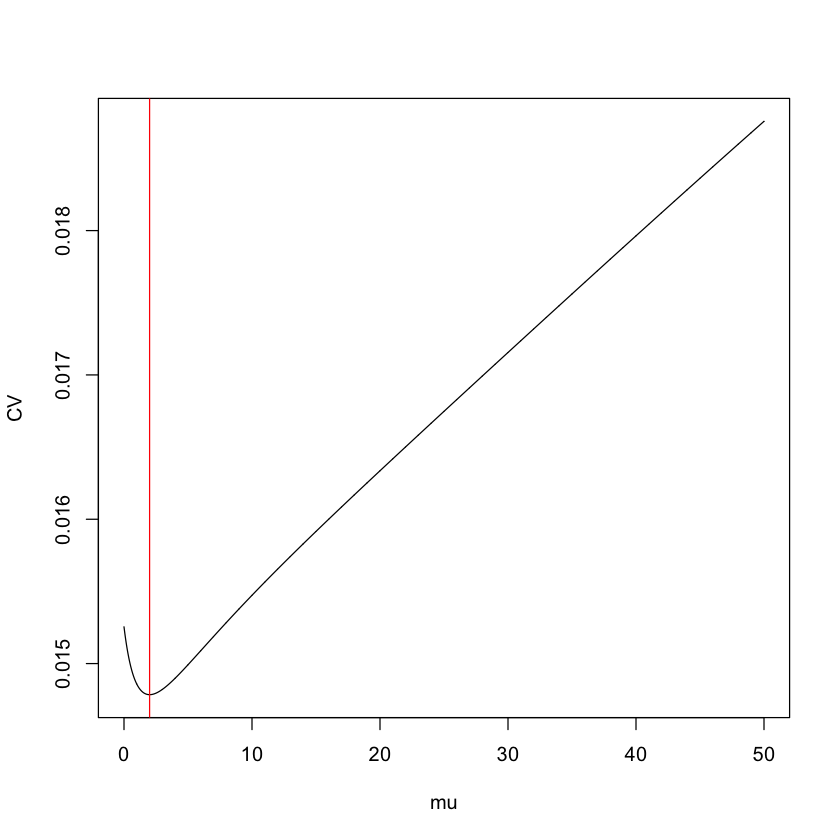

In [18]:
plot(RidgeModel1$lambda,RidgeModel1$GCV,type="l",xlab="mu",ylab="CV")
i<-which.min(RidgeModel1$GCV)
abline(v=RidgeModel1$lambda[i],col="red")

Подивимося на зміну впливу регресії відносно лямбди

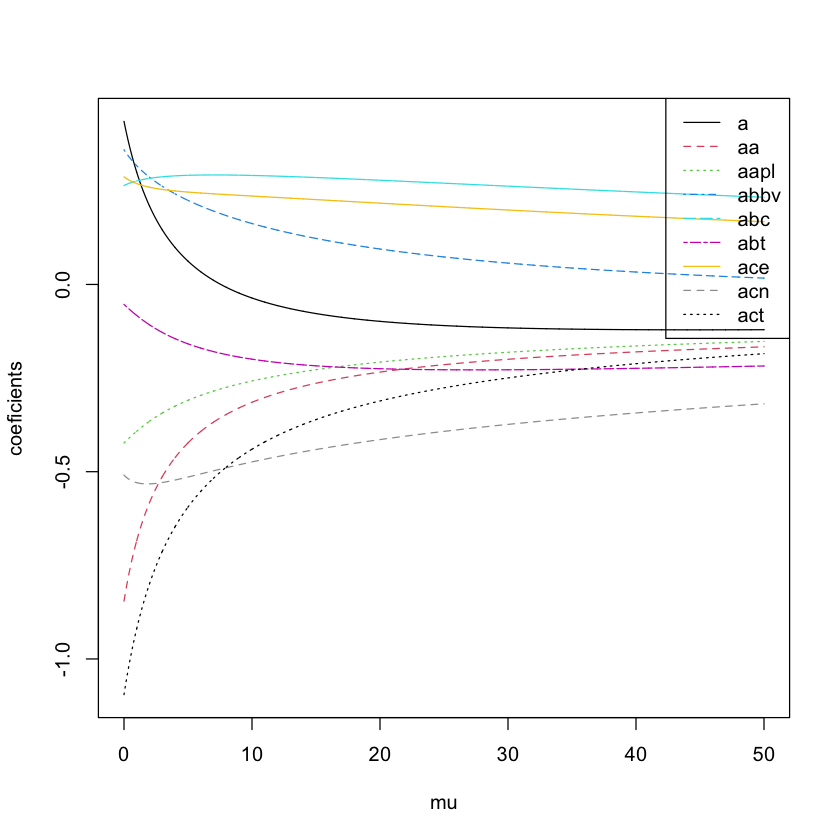

In [19]:
matplot(RidgeModel1$lambda,t(RidgeModel1$coef),type="l",col=1:9,lty=1:9,
            xlab="mu",ylab="coeficients")
legend("topright",col=1:9,legend=colnames(Data)[1:9],lty=1:9)

Коефіцієнти рознормовуємо, так як рідж модель тримає їх для нормованих даних.
Вираховуємо, що вільний член буде -F(Мх) + My, де Мх Му це середні значення регресорів та відгуку відповідно. F без вільного члена проходить через точку 0, а має проходити через точку (Мх, Му). Тобто F(Mx) = My. Для цього до F очевидно потрібрно додати -F(Мх) + My.

In [34]:
coefs1 <- matrix(RidgeModel1$coef[,i]/RidgeModel1$scales,ncol=1)
intercept1 <- -sum(matrix(colMeans(data_for1[,!names(data_for1) %in% 
            c("adbe", "tomorrow_adbe")])) * coefs1) + mean(data_for1$tomorrow_adbe)

lcoefs1 <- matrix(RidgeModel1$coef[,1]/RidgeModel1$scales,ncol=1)
lintercept1 <- -sum(matrix(colMeans(data_for1[,!names(data_for1) %in% 
            c("adbe", "tomorrow_adbe")])) * lcoefs1) + mean(data_for1$tomorrow_adbe)

Повторимо для другого набору вхідних даних, де в нас не тільки 50 точок, а всі, що доступні нам.

In [35]:
RidgeModel2 <- lm.ridge(tomorrow_adbe ~ .,
            data=data_for2[,!names(data_for2) %in% c("adbe")],lambda = seq(0, 50, .01))

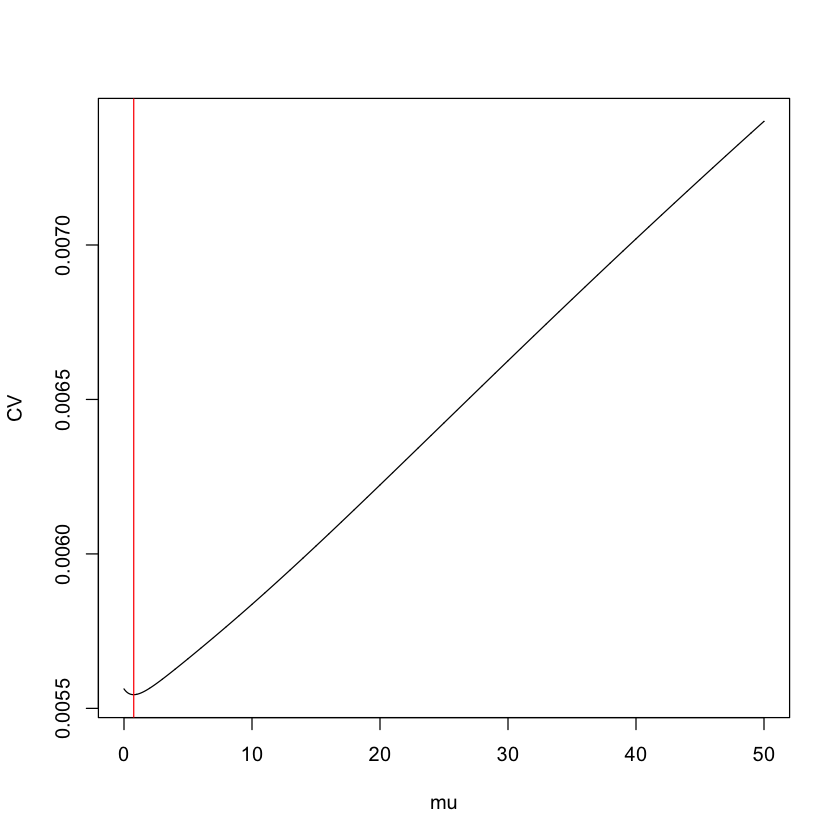

In [36]:
plot(RidgeModel2$lambda,RidgeModel2$GCV,type="l",xlab="mu",ylab="CV")
i<-which.min(RidgeModel2$GCV)
abline(v=RidgeModel2$lambda[i],col="red")

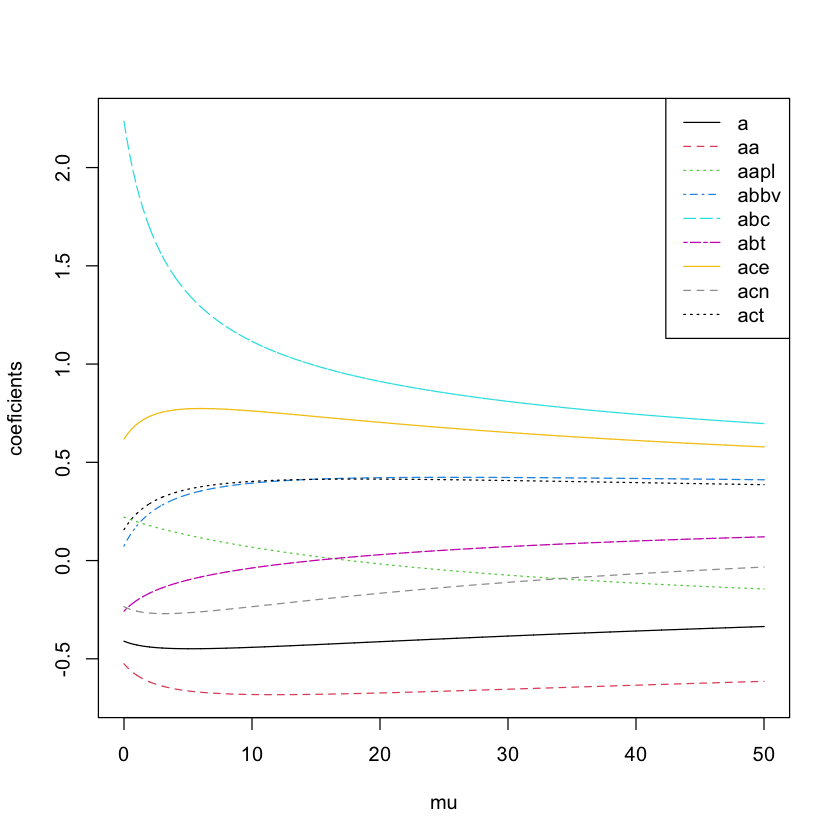

In [37]:
matplot(RidgeModel2$lambda,t(RidgeModel2$coef),type="l",col=1:9,lty=1:9,
        xlab="mu",ylab="coeficients")
legend("topright",col=1:9,legend=colnames(Data)[1:9],lty=1:9)

In [38]:
coefs2<-matrix(RidgeModel2$coef[,i]/RidgeModel2$scales,ncol=1)
intercept2 <- -sum(matrix(colMeans(data_for2[,!names(data_for2) %in% 
            c("adbe", "tomorrow_adbe")])) * coefs2) + mean(data_for2$tomorrow_adbe)

lcoefs2 <- matrix(RidgeModel2$coef[,1]/RidgeModel2$scales,ncol=1)
lintercept2 <- -sum(matrix(colMeans(data_for2[,!names(data_for2) %in% 
            c("adbe", "tomorrow_adbe")])) * lcoefs2) + mean(data_for2$tomorrow_adbe)

Згенеруємо прогнози наших моделей.

In [39]:
pred1 <- data.matrix(test[,!names(test) %in% c("adbe", "tomorrow_adbe")]) %*% coefs1 + intercept1
pred2 <- data.matrix(test[,!names(test) %in% c("adbe", "tomorrow_adbe")]) %*% coefs2 + intercept2
predl1 <- data.matrix(test[,!names(test) %in% c("adbe", "tomorrow_adbe")]) %*% lcoefs1 + lintercept1
predl2 <- data.matrix(test[,!names(test) %in% c("adbe", "tomorrow_adbe")]) %*% lcoefs2 + lintercept2

Наступні два шматки показують наші результати, у першому записаний результат, що отриманий після того, як лямбда було обране рівне 0. Що повністю співпадає зі звичайною лінійною регресією. Щоб не переписувати весь код я просто використала строчки коду  i <- 1 та перезапустила весь код. Тобто в цьому результаті бачимо середнє квадратичне відхилення для лінійної регресії.

In [40]:
sum((predl1 - test$tomorrow_adbe)**2) / 20
sum((predl2 - test$tomorrow_adbe)**2) / 20

[1] 1.227534

[1] 0.3737763

А тут вже результати моделей для рідж регресії з правильно обраним лямбда.

In [41]:
sum((pred1 - test$tomorrow_adbe)**2) / 20
sum((pred2 - test$tomorrow_adbe)**2) / 20

[1] 1.111878

[1] 0.3720169

Що ж, у висновку я б написала, що рідж регресія показує значне покращення на невеликих наборах даних, та майже не змінює результату для великих датасетів. Також можна побачити що модель, що використовує великий датасет, працює значно краще.

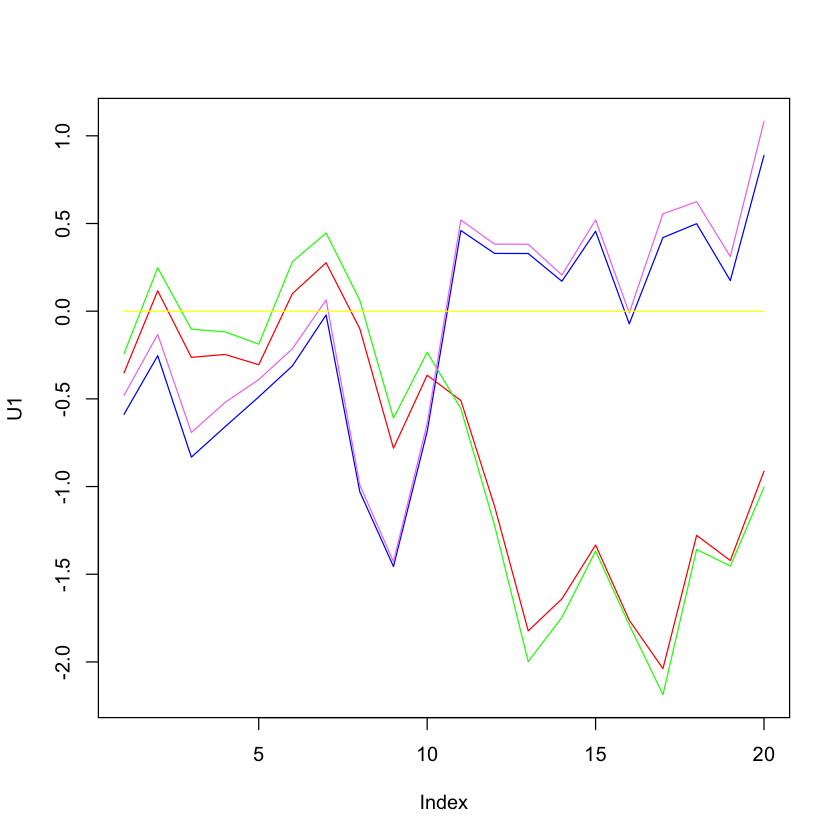

In [47]:
U1 <- pred1 - test$tomorrow_adbe
U2 <- pred2 - test$tomorrow_adbe
U3 <- predl1 - test$tomorrow_adbe
U4 <- predl2 - test$tomorrow_adbe

plot(U1,type="l",col="red",ylim=c(min(U1,U2,U3,U4),max(U1,U2,U3,U4)))
lines(U2,col="blue")
lines(U3,col="green")
lines(U4,col="violet")
lines(U1-U1,col="yellow")

Жовтим позначений 0. Зелена та фіолетова лінії є результатами лінійної регресії для малої та великої збірки даних. Також бачимо червону та синю лінії, що є результатами рідж регресії на цих даних. Можна побачити, що кожного разу результати дуже схожі у рідж моделі та звичайної, але рідж регресія дає невелике покращення. Також можна зауважити, що на дуже близьких точках до тих, на яких тренувалися, лінійна модель показує кращі результати, але сильно гірші в майбутньому.